In [1]:
from jupyterthemes import get_themes
from jupyterthemes.stylefx import set_nb_theme
themes = get_themes()
set_nb_theme(themes[1])

In [2]:
# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
# 4. a ipython magic to enable retina (high resolution) plots
# https://gist.github.com/minrk/3301035
%matplotlib inline
%load_ext watermark
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%watermark -a 'Ethen' -d -t -v -p numpy,pandas,matplotlib

Ethen 2017-10-14 15:52:35 

CPython 3.5.2
IPython 6.2.1

numpy 1.13.3
pandas 0.20.3
matplotlib 2.1.0


# Data Preprocessing

In [3]:
filepath = 'FirstBankUSA10000.csv'
data = pd.read_csv(filepath)
print('dimension:', data.shape)
data.head()

dimension: (10000, 58)


,ID,CUST_OPN_DT,NBROPN,AGE,CITY,STATE,PSTL_CD_5,PSTL_CD_4,NBR_OF_CHLD_IN_HH,OCCUP_OF_1ST_INDV,...,AUTO_LOAN_BAL,INV_FLG,INVST_AMT,ATM_FLG,POS_FLG,CSR_FLG,IVR_FLG,WEB_FLG,TLR_FLG,CRV
0,1,7/16/90,1,43.0,MINNEAPOLIS,MN,55416.0,4512.0,0.0,O,...,0.0,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2435.49
1,2,1/2/81,1,54.0,PELLA,IA,50219.0,2124.0,0.0,P,...,0.0,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.52
2,6,3/25/94,1,46.0,LONG LAKE,MN,55356.0,9636.0,1.0,O,...,0.0,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2723.29
3,11,2/25/94,3,53.0,COLORADO SPGS,CO,80907.0,6921.0,0.0,1,...,0.0,N,NaN,N,NaN,NaN,NaN,Y,Y,6589.69
4,15,3/3/94,1,74.0,ANN ARBOR,MI,48104.0,1810.0,0.0,1,...,0.0,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,243.54


Checked the percentage of NA columns using `data.isnull().sum() / data.shape[0]` and the following were dropped due to having a significant portion of NA values.

- CHLD_AGE_00_10, CHLD_AGE_11_17, CHLD_AGE_18_24, HOUSE_YR_BUILT, MAIL_ORD_BYR, MAIL_RESPONDERS, NBR_OF_VEHS, PRSNC_OF_POOL_FLG, PRPY_TYP, CDA_BAL, CKCOLBAL, CCDBAL, SVCOLBAL, OTHER_LOAN_FLG, AUTO_FLG, INVST_AMT, ATM_FLG, POS_FLG, CSR_FLG, IVR_FLG, WEB_FLG, TLR_FLG

For categorical variables, use `dataframe[colname].value_counts()` to check for the number of distinct categories, we'll choose to drop columns with too many distinct categories (number of categories is listed in the parenthesis)

- CITY (3026), could potentially bin them into regions
- STATE (52), could potentially bin them into regions
- OCCUP_OF_1ST_INDV (30), occupation
- ROLLUP-CDE (17), ethnicity
- HOM_MV(20), home market value

---

- Age, credit card age (can be derived from column CUST_OPN_DT) is potentially a better proxy

Numeric columns that were dropped

- PSTL_CD_5, PSTL_CD_4, zipcode number also implies regions

In [22]:
drop_cols = ['CHLD_AGE_00_10', 'CHLD_AGE_11_17', 'CHLD_AGE_18_24',
             'HOUSE_YR_BUILT', 'MAIL_ORD_BYR', 'MAIL_RESPONDERS',
             'NBR_OF_VEHS', 'PRSNC_OF_POOL_FLG', 'PRPY_TYP', 'CDA_BAL',
             'CKCOLBAL', 'CCDBAL', 'SVCOLBAL', 'OTHER_LOAN_FLG', 'Auto_Flg',
             'INVST_AMT', 'ATM_FLG', 'POS_FLG', 'CSR_FLG', 'IVR_FLG', 'WEB_FLG',
             'TLR_FLG', 'CITY', 'STATE', 'OCCUP_OF_1ST_INDV', 'ROLLUP-CDE',
             'HOM_MV', 'AGE', 'PSTL_CD_5', 'PSTL_CD_4']
date_cols = ['CUST_OPN_DT']
cat_cols = ['EDU1', 'CDA_ID', 'CHK_ID', 'SAV_ID', 'MTG_ID',
            'EQ_LINE_FLG', 'EQ_LOAN_FLG', 'INV_FLG', 'CCD_FLG']
# str_cols are essentially categorical columns,
# but includes NA values, thus they are read in as is and
# converted to categorical type after imputing the unknowns
str_cols = ['OWN_RENT', 'PRM_PLUS_MRTL_STS', 'PRM_PLUS_PRSNC_OF_CHLD', 'GNDR_OF_1ST_INDV']
num_cols = ['NBROPN',
            'NBR_OF_CHLD_IN_HH', 'HH_ADLTS_PE_PLUS_CNT',
            'PRM_PLUS_LG_OF_RSD', 'EDU1', 'INCOME',
            'AGGR_VEH_MV', 'AST_IXI', 'MTG_TOT_BAL_AMT',
            'HOM_EQTY_LINE_AMT', 'HOM_EQTY_LOAN_AMT', 'OTHER_LOAN_BAL',
            'AUTO_LOAN_BAL']
label_col = 'CRV'
ids_col = 'ID'

In [23]:
for col in [7, 5, 6, 3]:
    print(num_cols[col])

AST_IXI
INCOME
AGGR_VEH_MV
PRM_PLUS_LG_OF_RSD


In [5]:
cat_dtypes = {col: 'category' for col in cat_cols}
read_csv_info = {'dtype': cat_dtypes,
                 'parse_dates': date_cols,
                 'infer_datetime_format': True}
use_cols = cat_cols + str_cols + num_cols + date_cols + [ids_col]
if label_col is not None:
    use_cols += [label_col]
    
data = pd.read_csv(filepath, usecols = use_cols, **read_csv_info)
print('dimension:', data.shape)
data.head()

dimension: (10000, 28)


,ID,CUST_OPN_DT,NBROPN,NBR_OF_CHLD_IN_HH,OWN_RENT,PRM_PLUS_LG_OF_RSD,PRM_PLUS_MRTL_STS,PRM_PLUS_PRSNC_OF_CHLD,EDU1,GNDR_OF_1ST_INDV,...,MTG_ID,MTG_TOT_BAL_AMT,EQ_LINE_FLG,HOM_EQTY_LINE_AMT,EQ_LOAN_FLG,HOM_EQTY_LOAN_AMT,OTHER_LOAN_BAL,AUTO_LOAN_BAL,INV_FLG,CRV
0,1,1990-07-16,1,0.0,O,4.0,B,N,1,F,...,N,0.0,N,0.0,N,0.0,0.0,0.0,N,2435.49
1,2,1981-01-02,1,0.0,O,9.0,S,N,1,F,...,N,0.0,N,0.0,N,0.0,0.0,0.0,N,-0.52
2,6,1994-03-25,1,1.0,O,15.0,M,Y,1,M,...,N,0.0,N,0.0,N,0.0,0.0,0.0,N,2723.29
3,11,1994-02-25,3,0.0,O,7.0,B,N,3,M,...,N,0.0,N,0.0,N,0.0,0.0,0.0,N,6589.69
4,15,1994-03-03,1,0.0,O,15.0,M,N,3,M,...,N,0.0,N,0.0,N,0.0,0.0,0.0,N,243.54


In [6]:
now = '2017-10-13'

# there's only 1 date column in the date_cols list,
# use it to compute the recency
date_col = date_cols[0]
data[date_col] = (pd.Timestamp(now) - data[date_col]).dt.days

In [7]:
# OWN_RENT has 5 distinct types, but there's only 2 records
# for type "C", 1 record for both type "A", "B", these records
# are simply dropped. Type "O" and "R" is kept
data = data[~data['OWN_RENT'].isin(['C', 'A', 'B'])]

# null values per row
data['NAN_COUNT'] = data.isnull().sum(axis = 1)

# NAN is filled with "unknown", after that we can
# safely convert them to categorical tye
data[str_cols] = data[str_cols].fillna('unknown')
for str_col in str_cols:
    data[str_col] = data[str_col].astype('category')

In [8]:
from sklearn.preprocessing import LabelEncoder


ids = data[ids_col].values
label_binned = pd.cut(
    data[label_col].values, bins = [-np.inf, -10000, 0, 10000, np.inf])
label_encoder = LabelEncoder()
label = label_encoder.fit_transform(label_binned)

data = data.drop([ids_col, label_col], axis = 1)
data.head()

,CUST_OPN_DT,NBROPN,NBR_OF_CHLD_IN_HH,OWN_RENT,PRM_PLUS_LG_OF_RSD,PRM_PLUS_MRTL_STS,PRM_PLUS_PRSNC_OF_CHLD,EDU1,GNDR_OF_1ST_INDV,HH_ADLTS_PE_PLUS_CNT,...,MTG_ID,MTG_TOT_BAL_AMT,EQ_LINE_FLG,HOM_EQTY_LINE_AMT,EQ_LOAN_FLG,HOM_EQTY_LOAN_AMT,OTHER_LOAN_BAL,AUTO_LOAN_BAL,INV_FLG,NAN_COUNT
0,9951,1,0.0,O,4.0,B,N,1,F,1.0,...,N,0.0,N,0.0,N,0.0,0.0,0.0,N,0
1,13433,1,0.0,O,9.0,S,N,1,F,1.0,...,N,0.0,N,0.0,N,0.0,0.0,0.0,N,0
2,8603,1,1.0,O,15.0,M,Y,1,M,2.0,...,N,0.0,N,0.0,N,0.0,0.0,0.0,N,0
3,8631,3,0.0,O,7.0,B,N,3,M,1.0,...,N,0.0,N,0.0,N,0.0,0.0,0.0,N,0
4,8625,1,0.0,O,15.0,M,N,3,M,2.0,...,N,0.0,N,0.0,N,0.0,0.0,0.0,N,0


In [9]:
data.describe()

,CUST_OPN_DT,NBROPN,NBR_OF_CHLD_IN_HH,PRM_PLUS_LG_OF_RSD,HH_ADLTS_PE_PLUS_CNT,INCOME,AGGR_VEH_MV,AST_IXI,MTG_TOT_BAL_AMT,HOM_EQTY_LINE_AMT,HOM_EQTY_LOAN_AMT,OTHER_LOAN_BAL,AUTO_LOAN_BAL,NAN_COUNT
count,9996.000000,9996.000000,9147.000000,9977.000000,9147.000000,9.217000e+03,9977.000000,9.732000e+03,9996.000000,9988.000000,9988.000000,9988.000000,9988.00000,9996.000000
mean,7185.351441,1.859344,0.585329,7.484113,1.973325,6.867578e+04,122.255187,9.898313e+04,13395.383064,1589.516566,1506.606333,575.034917,1004.25725,0.633854
std,4180.526159,1.465298,0.842777,5.579111,0.783152,1.125724e+05,176.932071,2.265338e+05,48218.932791,13173.149960,14262.483698,6137.361007,4286.94379,1.962324
min,-17912.000000,1.000000,0.000000,0.000000,1.000000,2.400000e+01,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,4581.000000,1.000000,0.000000,2.000000,1.000000,3.500000e+04,0.000000,6.700750e+03,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,6000.500000,1.000000,0.000000,7.000000,2.000000,6.250000e+04,40.000000,2.859950e+04,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
75%,9164.500000,2.000000,1.000000,14.000000,2.000000,8.750000e+04,200.000000,8.986825e+04,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
max,18548.000000,19.000000,6.000000,15.000000,6.000000,8.156000e+06,3060.000000,2.000000e+06,649900.000000,407296.730000,696693.640000,205548.660000,52975.65000,11.000000


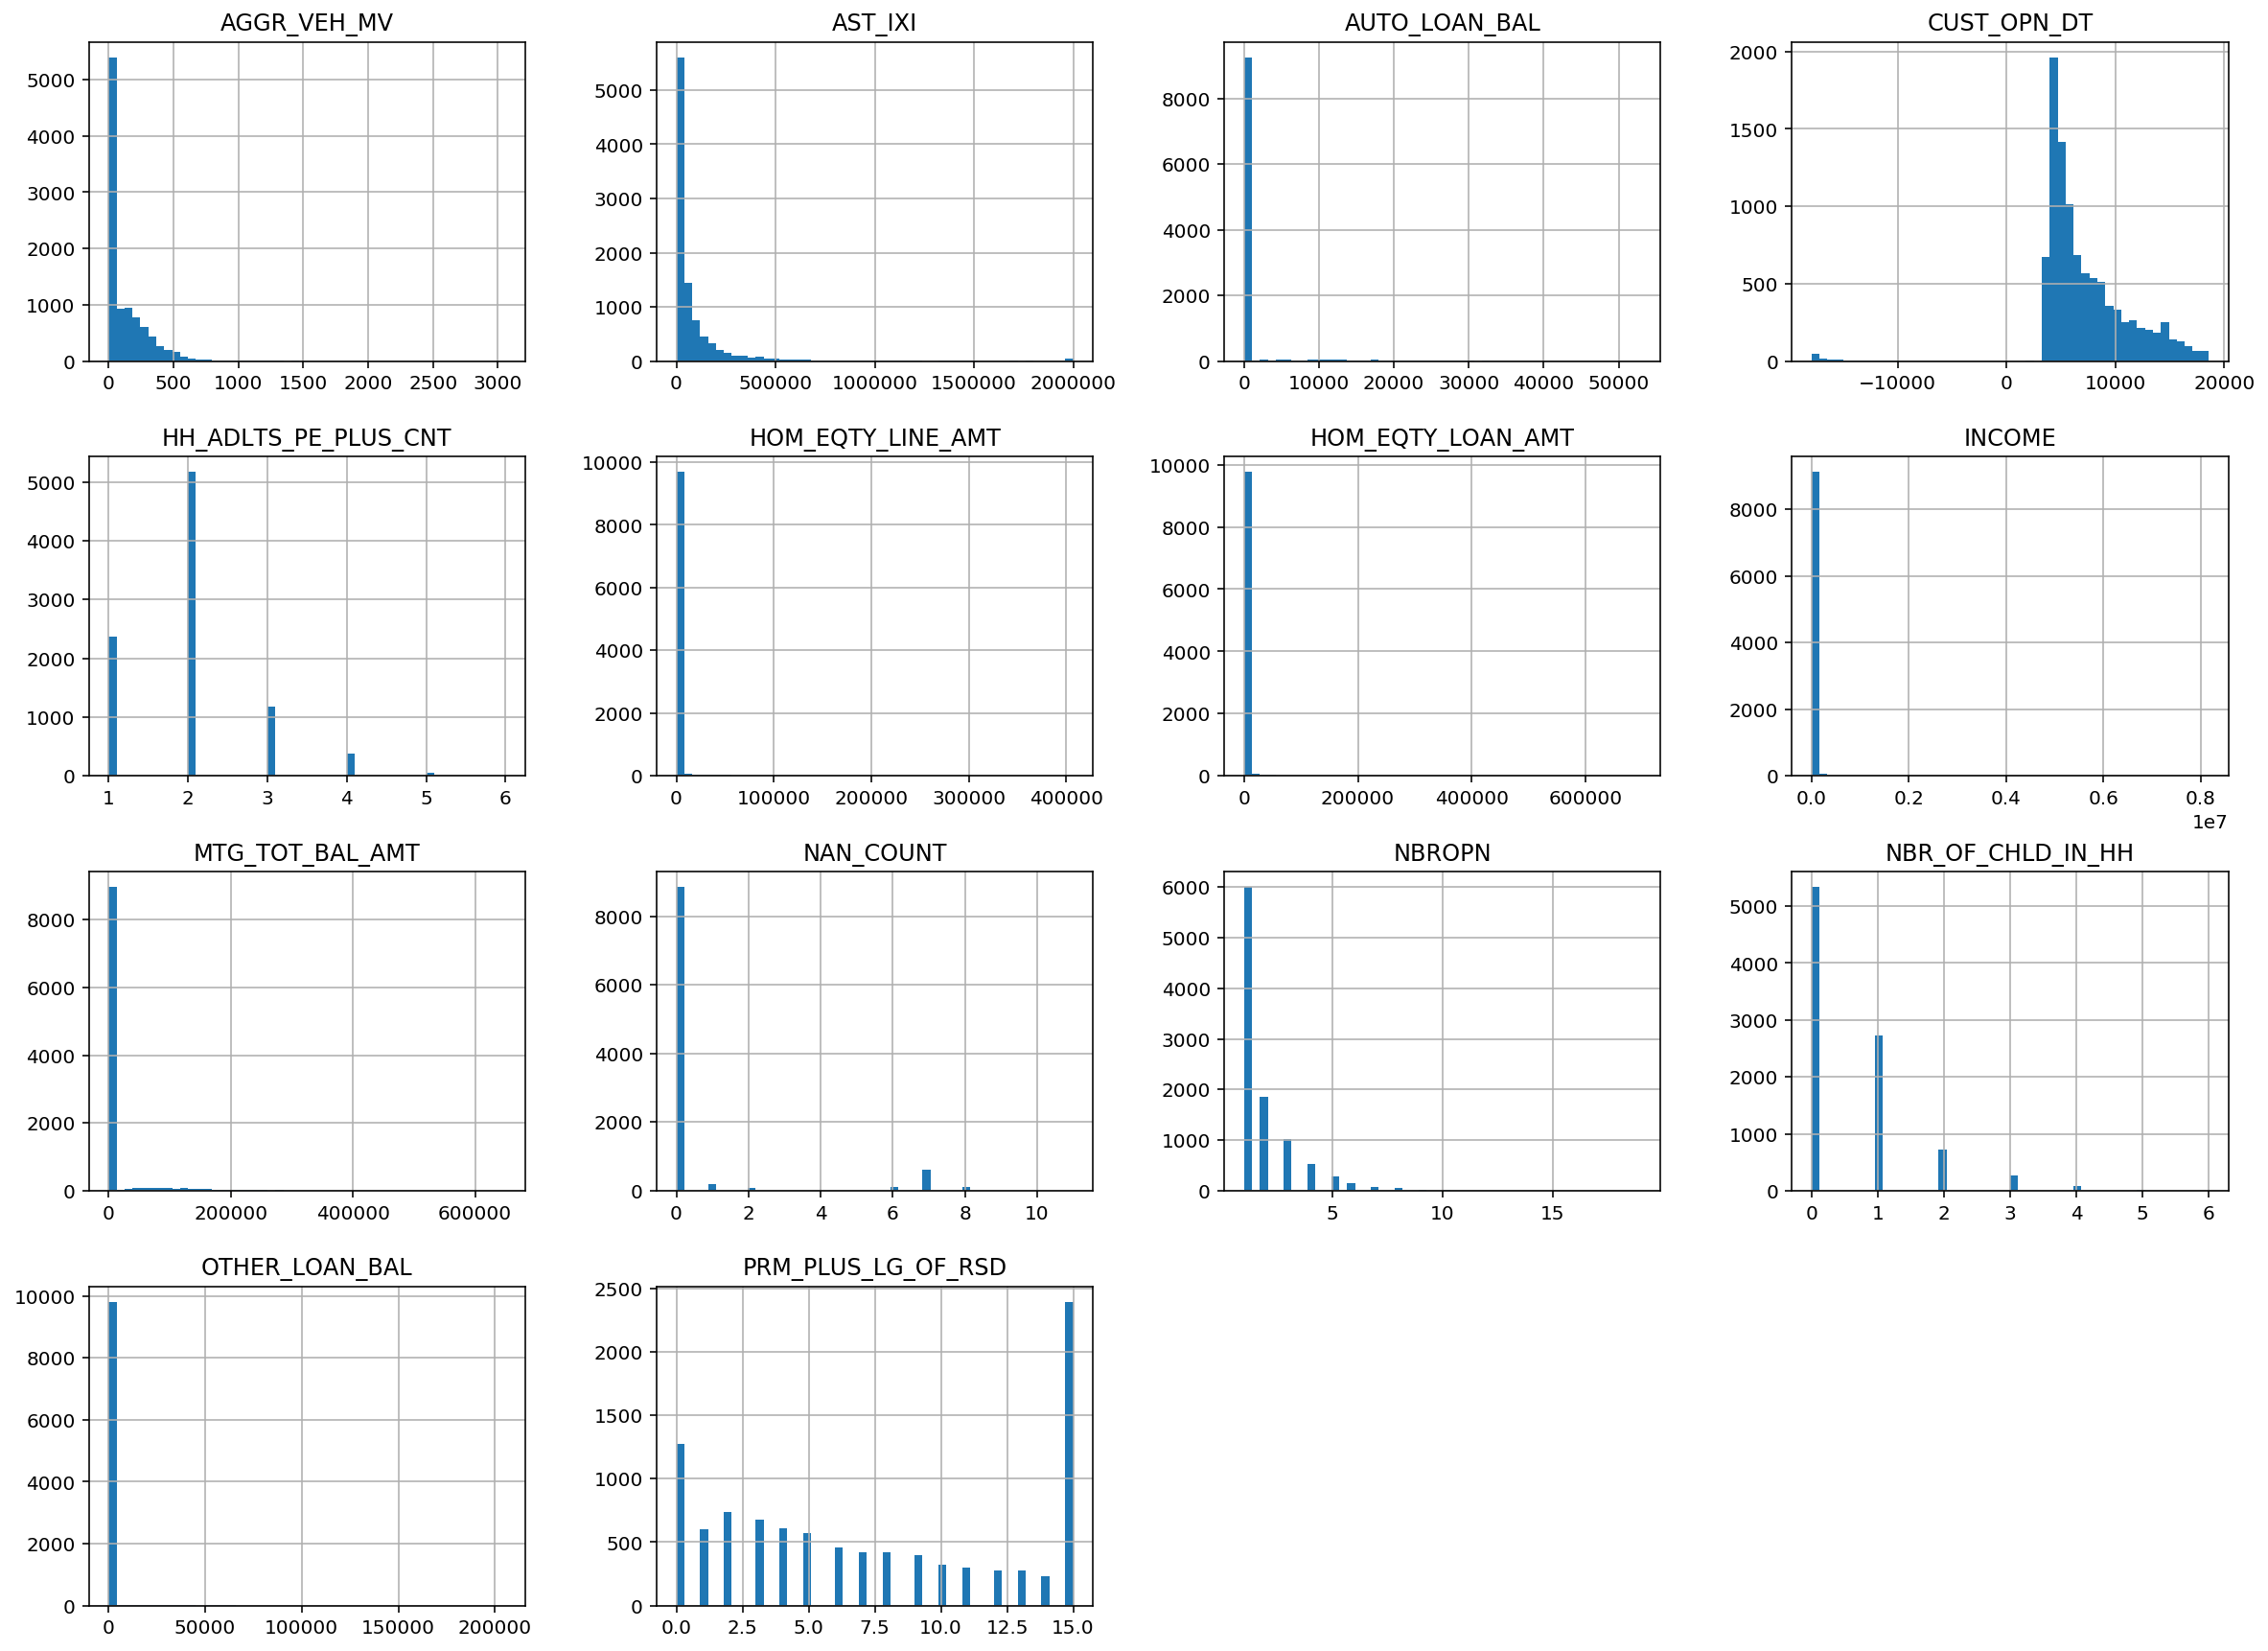

In [10]:
data.hist(bins = 50, figsize = (20, 15))
plt.show()

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

test_size = 0.1
split_random_state = 1234
X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(
    data.values, label, ids, test_size = test_size,
    random_state = split_random_state, stratify = label)

In [12]:
# column NBR_OF_CHLD_IN_HH, HH_ADLTS_PE_PLUS_CNT
# contains 0.08 percent NAN values and are imputed with the mode,
# assuming the child and adult per household follows the norm
# HOM_EQTY_LINE_AMT, HOM_EQTY_LOAN_AMT, OTHER_LOAN_BAL, AUTO_LOAN_BAL
# contains very very few NAN values, and will be filled with the median
fill_mode_cols = ['NBR_OF_CHLD_IN_HH', 'HH_ADLTS_PE_PLUS_CNT']
fill_mode_cols = [data.columns.get_loc(col) for col in fill_mode_cols]
fill_median_cols = ['INCOME', 'AGGR_VEH_MV', 'PRM_PLUS_LG_OF_RSD', 'AST_IXI',
                    'HOM_EQTY_LINE_AMT', 'HOM_EQTY_LOAN_AMT',
                    'OTHER_LOAN_BAL', 'AUTO_LOAN_BAL']
fill_median_cols = [data.columns.get_loc(col) for col in fill_median_cols]
fill_median_cols

[10, 11, 4, 12, 20, 22, 23, 24]

In [13]:
# PRM_PLUS_LG_OF_RSD, INCOME, AGGR_VEH_MV, AST_IXI
# HOM_EQTY_LINE_AMT, HOM_EQTY_LOAN_AMT, OTHER_LOAN_BAL,
# AUTO_LOAN_BAL

In [14]:
num_cols = [data.columns.get_loc(col) for col in num_cols]
cat_cols = [data.columns.get_loc(col) for col in cat_cols + str_cols]
cat_cols

[7, 13, 14, 16, 17, 19, 21, 25, 15, 3, 5, 6, 8]

In [15]:
from sklearn.ensemble import RandomForestClassifier
from custom_transformers import Preprocess, MultipleImputer, BoxCoxTransformer

# make it work solely with pandas DataFrame
boxcox_tr = BoxCoxTransformer(fill_mode_cols + fill_median_cols)
strategies = {'mode': fill_mode_cols, 'median': fill_median_cols}
imputer = MultipleImputer(strategies)
preprocess = Preprocess(num_cols = num_cols, cat_cols = cat_cols)
rf = RandomForestClassifier()

pipeline = Pipeline([
    ('boxcox', boxcox_tr),
    ('impute', imputer),
    ('preprocess', preprocess),
    ('rf', rf)
])
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('boxcox', BoxCoxTransformer(copy=True, eps=1e-08,
         transformed_features=[2, 9, 10, 11, 4, 12, 20, 22, 23, 24])), ('impute', MultipleImputer(copy=True, missing_values='NaN',
        strategies={'median': [10, 11, 4, 12, 20, 22, 23, 24], 'mode': [2, 9]})), ('preprocess', Preprocess(cat...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [16]:
rf = pipeline.named_steps['rf']
rf.feature_importances_

array([ 0.04075371,  0.02423464,  0.03970497,  0.10199015,  0.01567865,
        0.11969831,  0.10702199,  0.24014031,  0.02509501,  0.00340294,
        0.00270783,  0.00492858,  0.02159436,  0.00225576,  0.00800425,
        0.00649761,  0.00545609,  0.00063316,  0.00539495,  0.00410715,
        0.00936602,  0.00562542,  0.01060905,  0.01093555,  0.00351707,
        0.01550475,  0.00390641,  0.00535603,  0.00223452,  0.0027341 ,
        0.00743003,  0.00384042,  0.00987831,  0.00884842,  0.01002415,
        0.0058386 ,  0.00288999,  0.00524693,  0.01165032,  0.01238138,
        0.01382203,  0.00084859,  0.01354609,  0.011287  ,  0.00186191,
        0.01320132,  0.01340753,  0.00236109,  0.00254656])

In [17]:
def viz_importance(model, feature_names, n_features):
    """Visualize the relative importance of predictors"""
    
    # apart from the mean feature importance, for scikit-learn we can access
    # each individual tree's feature importance and compute the standard deviation
    importances = model.feature_importances_
    tree_importances = [tree.feature_importances_ for tree in model.estimators_]
    importances_std = np.std(tree_importances, axis = 0)
    
    # sort the importance in decreasing order
    idx = np.argsort(importances)[-n_features:]
    print(idx)
    names = feature_names[idx]
    scores = importances[idx]
    scores_std = importances_std[idx]
    
    y_pos = np.arange(1, n_features + 1)
    plt.barh(y_pos, scores, align = 'center', xerr = scores_std)
    plt.yticks(y_pos, names)
    plt.xlabel('Importance')
    plt.title('Feature Importance Plot')

In [18]:
num_cols

[1, 2, 9, 4, 7, 10, 11, 12, 18, 20, 22, 23, 24]

In [19]:
cat_cols

[7, 13, 14, 16, 17, 19, 21, 25, 15, 3, 5, 6, 8]

[15 30 14 33 20 32 34 22 23 43 38 39 45 46 42 40 25  4 12  1  8  2  0  3  6
  5  7]


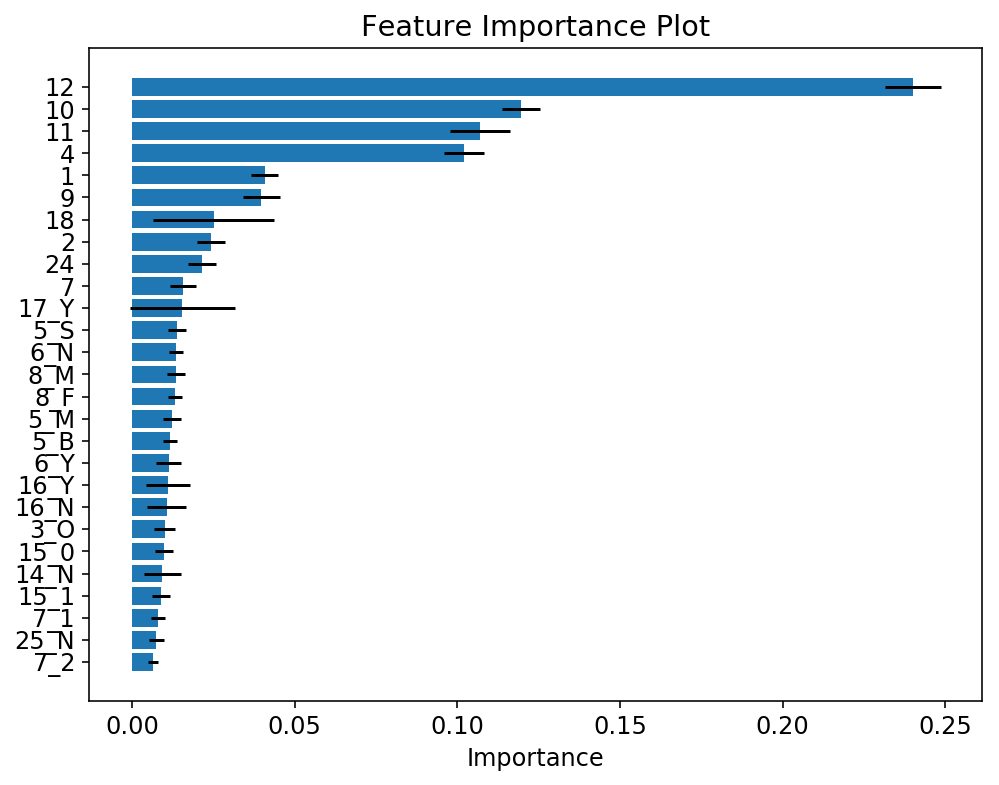

In [20]:
# change default figure and font size
plt.rcParams['figure.figsize'] = 8, 6 
plt.rcParams['font.size'] = 12

# visualize the feature importance of every variable
preprocess = pipeline.named_steps['preprocess']
viz_importance(rf, np.asarray(preprocess.colnames_), X_train.shape[1])

In [21]:
from sklearn.metrics import accuracy_score



accuracy_score(pipeline.predict_proba(X_test), y_test)

ValueError: Classification metrics can't handle a mix of continuous-multioutput and multiclass targets

In [ ]:
for i in boxcox_tr.transformed_features_:
    print(X_train[:, i])

In [ ]:
data.select_dtypes(['float', 'int']).columns

In [ ]:
# PRM_PLUS_LG_OF_RSD, INCOME, AGGR_VEH_MV, AST_IXI
# HOM_EQTY_LINE_AMT, HOM_EQTY_LOAN_AMT, OTHER_LOAN_BAL,
# AUTO_LOAN_BAL

In [ ]:
# impute with different strategy after computing on the
# record without NAN

In [ ]:
data.isnull().sum()

In [ ]:
# AST_IXI : 0.02
# AGGR_VEH_MV : 0.002
# INCOME : 0.077
AST_IXI